In [2]:
from pystac_client import Client
import geopandas as gpd
import rasterio
from pathlib import Path
import pandas as pd
import requests
import planetary_computer as pc
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt

In [3]:
stac_url = "https://planetarycomputer.microsoft.com/api/stac/v1"

In [4]:
in_dir = Path('out')

files = sorted(in_dir.rglob("*_LSTC.tif"))

records = []

for f in files:
    parts = f.name.split("_")
    pathrow = parts[2]
    acq_date = parts[3]

    datetime = pd.to_datetime(acq_date, format = "%Y%m%d")

    records.append({
        "file": f,
        "pathrow": pathrow,
        "acq_date": acq_date,
    })

df = pd.DataFrame(records)
df

file pathrow  acq_date
0   out\DAY\LC08_L1TP_089083_20191106_20200825_02_...  089083  20191106
1   out\DAY\LC08_L1TP_089083_20200109_20200823_02_...  089083  20200109
2   out\DAY\LC08_L1TP_089083_20200125_20200823_02_...  089083  20200125
3   out\DAY\LC08_L1TP_089084_20191106_20200825_02_...  089084  20191106
4   out\DAY\LC08_L1TP_090083_20191113_20200825_02_...  090083  20191113
5   out\DAY\LC08_L1TP_090083_20191215_20201022_02_...  090083  20191215
6   out\DAY\LC08_L1TP_090083_20191231_20200824_02_...  090083  20191231
7   out\DAY\LC08_L1TP_090083_20200201_20200823_02_...  090083  20200201
8   out\DAY\LC08_L1TP_090083_20200217_20200823_02_...  090083  20200217
9   out\DAY\LC08_L1TP_090084_20191113_20200825_02_...  090084  20191113
10  out\DAY\LC08_L1TP_090084_20191215_20201022_02_...  090084  20191215
11  out\NIGHT\LC08_L1GT_208160_20191226_20200824_0...  208160  20191226
12  out\NIGHT\LC08_L1GT_208161_20191226_20200824_0...  208161  20191226
13  out\NIGHT\LC08_L1GT_209160_20191217_20201023_0...  209160  20191217
14  out\NIGHT\LC08_L1GT_209161_20191115_20200825_0...  209161  20191115
15  out\NIGHT\LC08_L1GT_209161_20191217_20201023_0...  209161  20191217

In [5]:
bbox_gpkg = gpd.read_file("bbox_sm.gpkg")
bbox_4326 = bbox_gpkg.to_crs("EPSG:4326")
minx, miny, maxx, maxy = bbox_4326.total_bounds
bbox = [minx, miny, maxx, maxy]

In [6]:
client = Client.open(stac_url)

start_date = "2019-11-01"
end_date = "2020-02-01"

query = client.search(
    bbox = bbox,
    collections = "landsat-c2-l2",
    datetime=f"{start_date}/{end_date}",
    query={"eo:cloud_cover": {"lt": 10}},
)

items = list(query.items())
print(f"Found: {len(items)} datasets")

Found: 12 datasets


In [7]:
first = items[0]
print(first.id)
print(list(first.assets.keys()))

LC08_L2SP_090083_20200201_02_T1
['qa', 'ang', 'red', 'blue', 'drad', 'emis', 'emsd', 'trad', 'urad', 'atran', 'cdist', 'green', 'nir08', 'lwir11', 'swir16', 'swir22', 'coastal', 'mtl.txt', 'mtl.xml', 'mtl.json', 'qa_pixel', 'qa_radsat', 'qa_aerosol', 'tilejson', 'rendered_preview']


In [8]:
stac_records = []

for item in items:
    scene_id = item.id
    
    dt = pd.to_datetime(item.datetime)
    acq_date = dt.normalize()
    date = acq_date.strftime("%Y%m%d")

    wrs_path = item.properties.get("landsat:wrs_path")
    wrs_row = item.properties.get("landsat:wrs_row")
    pathrow = f"{int(wrs_path):03d}{int(wrs_row):03d}"

    stac_records.append({
        "scene_id": scene_id,
        "pathrow": pathrow,
        "acq_date": date,
    })

stac_df = pd.DataFrame(stac_records)
stac_df.head()

scene_id pathrow  acq_date
0  LC08_L2SP_090083_20200201_02_T1  090083  20200201
1  LC08_L2SP_089083_20200125_02_T1  089083  20200125
2  LC08_L2SP_090083_20191231_02_T1  090083  20191231
3  LE07_L2SP_089084_20191216_02_T1  089084  20191216
4  LC08_L2SP_090083_20191215_02_T1  090083  20191215

In [9]:
matches = df.merge(
    stac_df,
    on=["pathrow", "acq_date"],
    how="inner"
)

In [10]:
out_dir = Path('data/validate')
out_dir.mkdir(exist_ok=True, parents=True)

scene_ids = matches["scene_id"].dropna().unique().tolist()
print(f"Matching scenes: {len(scene_ids)}")

client = Client.open(stac_url)

start_date = "2019-11-01"
end_date = "2020-02-01"

query2 = client.search(
    bbox = bbox,
    collections = "landsat-c2-l2",
    datetime=f"{start_date}/{end_date}",
    ids = scene_ids
)

items = list(query2.items())
print(len(items))

Matching scenes: 8
8


In [11]:
# first = items[0]
# print(first.id)
# print(list(first.assets.keys()))

In [12]:
# asset_keys = ["atran"]

# for item in items:
#     sid = item.id
#     for asset_key in asset_keys:
#         signed = pc.sign(item.assets[asset_key])
#         url = signed.href
#         out_path = out_dir / f"{sid}_{asset_key}.tif"

#         with requests.get(url, stream=True) as r:
#             r.raise_for_status()
#             with open(out_path, "wb") as f:
#                 for chunk in r.iter_content(8192):
#                     f.write(chunk)

In [13]:
matches = matches.set_index("scene_id")

LC08_L2SP_089083_20191106_02_T1: RMSE = 4.075, MAE = 4.004
LC08_L2SP_089083_20191106_02_T1 model C: 294.7190460205078 324.7117408752441 vali C: 291.18963199999996 324.0880745


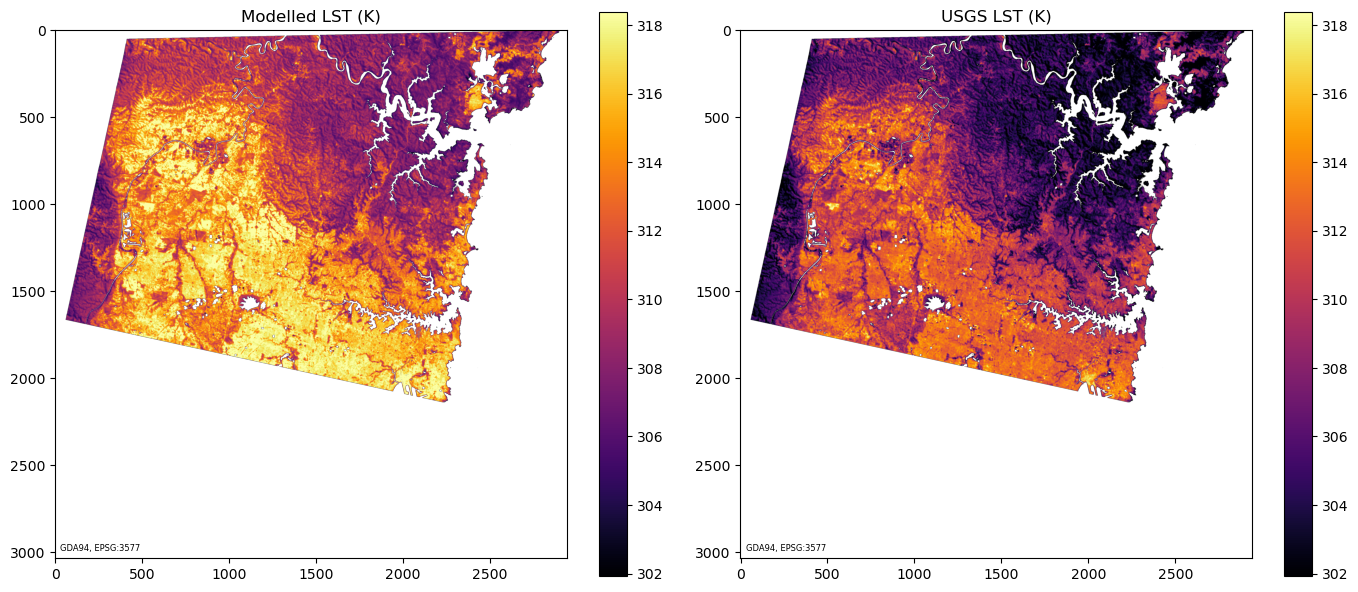

LC08_L2SP_089083_20200125_02_T1: RMSE = 6.350, MAE = 6.147
LC08_L2SP_089083_20200125_02_T1 model C: 301.05463829040525 327.5610984802246 vali C: 284.31257575999996 328.38110761999997


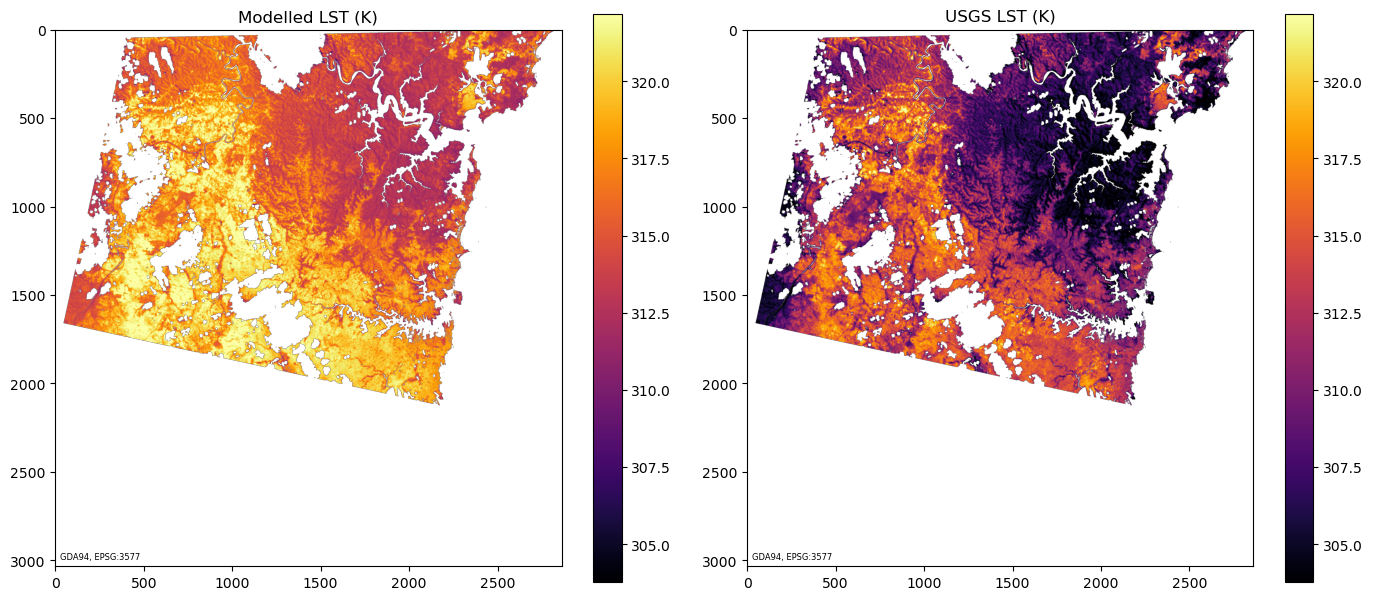

LC08_L2SP_089084_20191106_02_T1: RMSE = 4.155, MAE = 4.077
LC08_L2SP_089084_20191106_02_T1 model C: 292.0378192901611 325.372297668457 vali C: 286.7120258 328.2409688


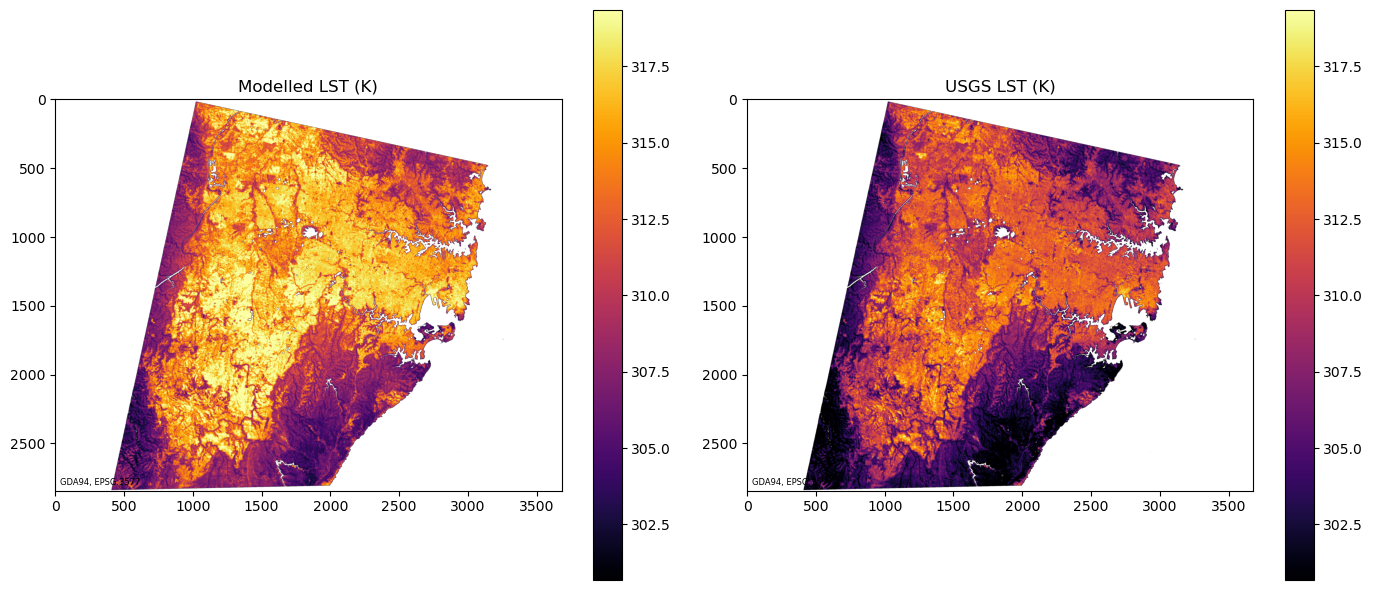

LC08_L2SP_090083_20191113_02_T1: RMSE = 5.861, MAE = 5.794
LC08_L2SP_090083_20191113_02_T1 model C: 297.3346485137939 331.0415977478027 vali C: 290.52653612 326.81223644


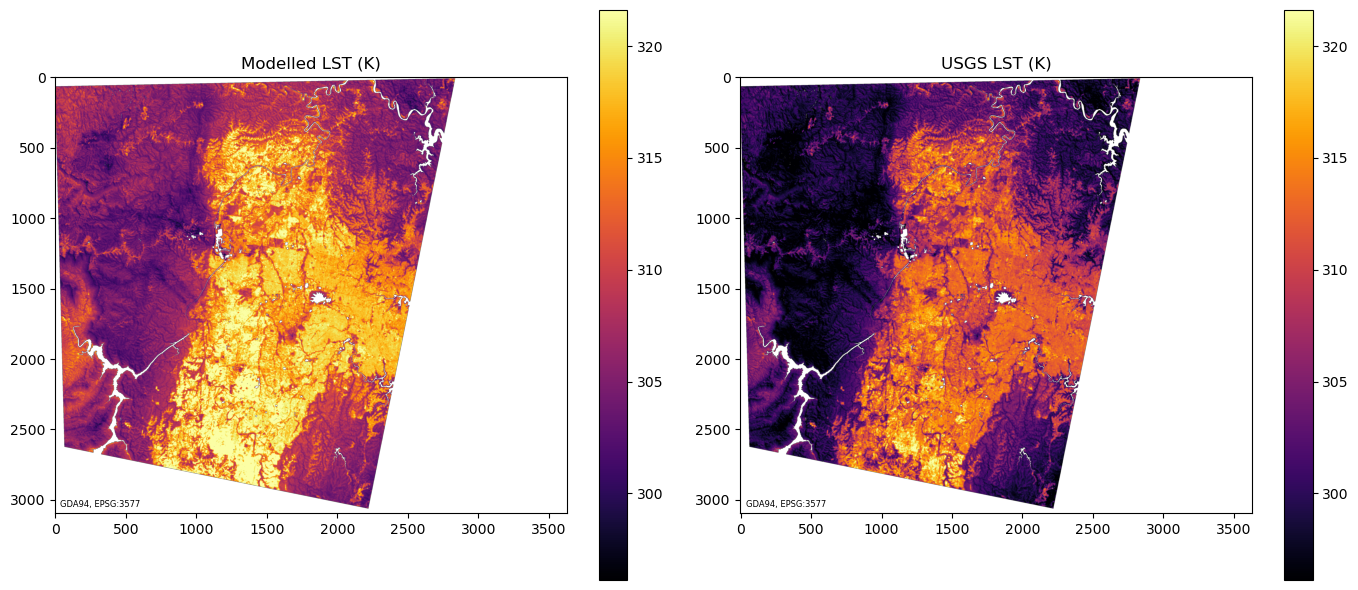

LC08_L2SP_090083_20191215_02_T1: RMSE = 9.586, MAE = 9.501
LC08_L2SP_090083_20191215_02_T1 model C: 304.9359725952148 392.10565795898435 vali C: 293.98899038 372.9999407


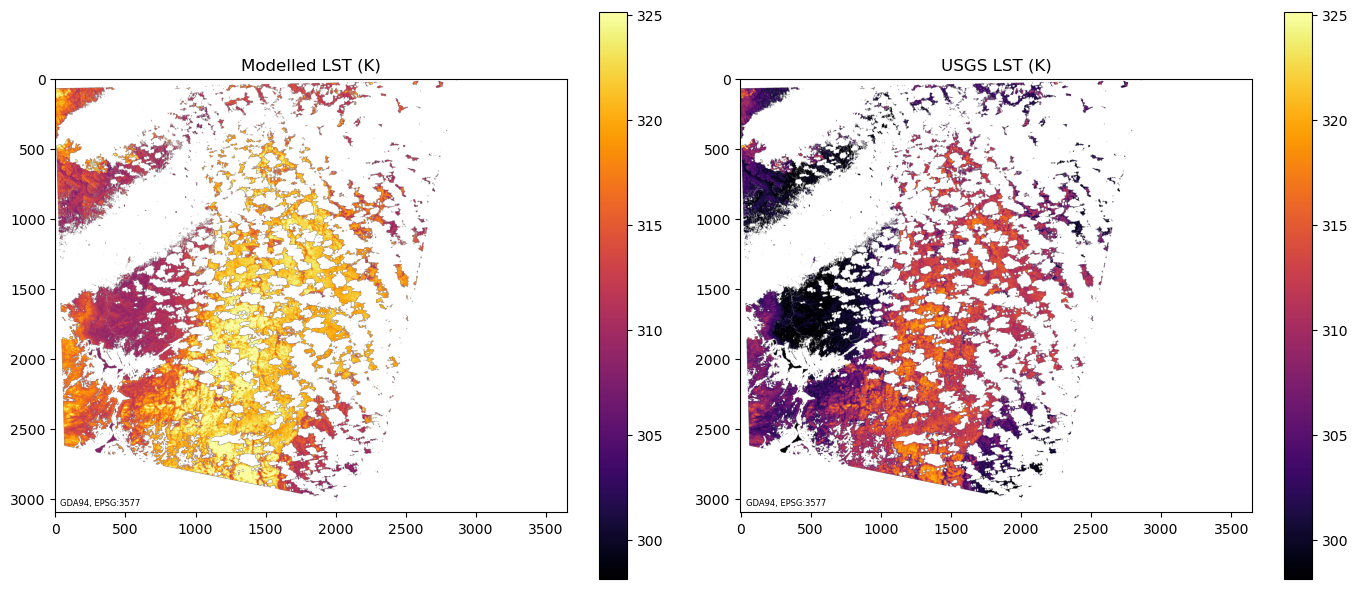

LC08_L2SP_090083_20191231_02_T1: RMSE = 9.848, MAE = 9.781
LC08_L2SP_090083_20191231_02_T1 model C: 306.5932334899902 349.3880142211914 vali C: 294.65208626000003 343.4682479


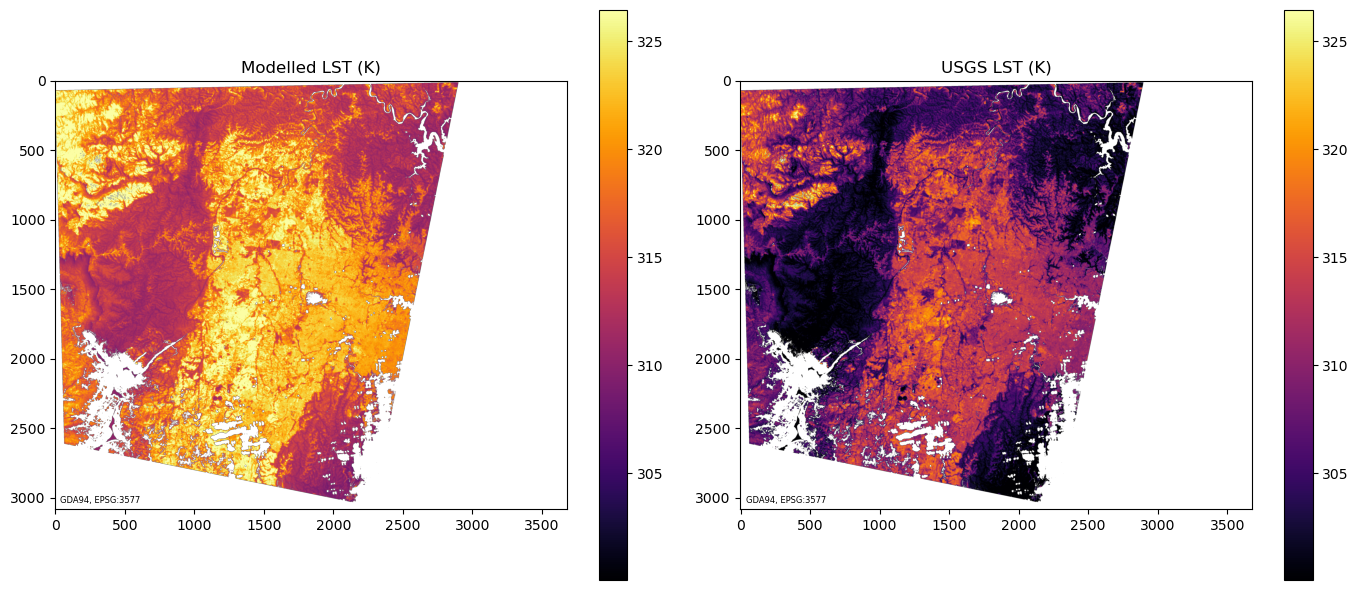

LC08_L2SP_090083_20200201_02_T1: RMSE = 6.969, MAE = 6.779
LC08_L2SP_090083_20200201_02_T1 model C: 294.24557914733884 394.7172454833984 vali C: 270.54820922 372.9999407


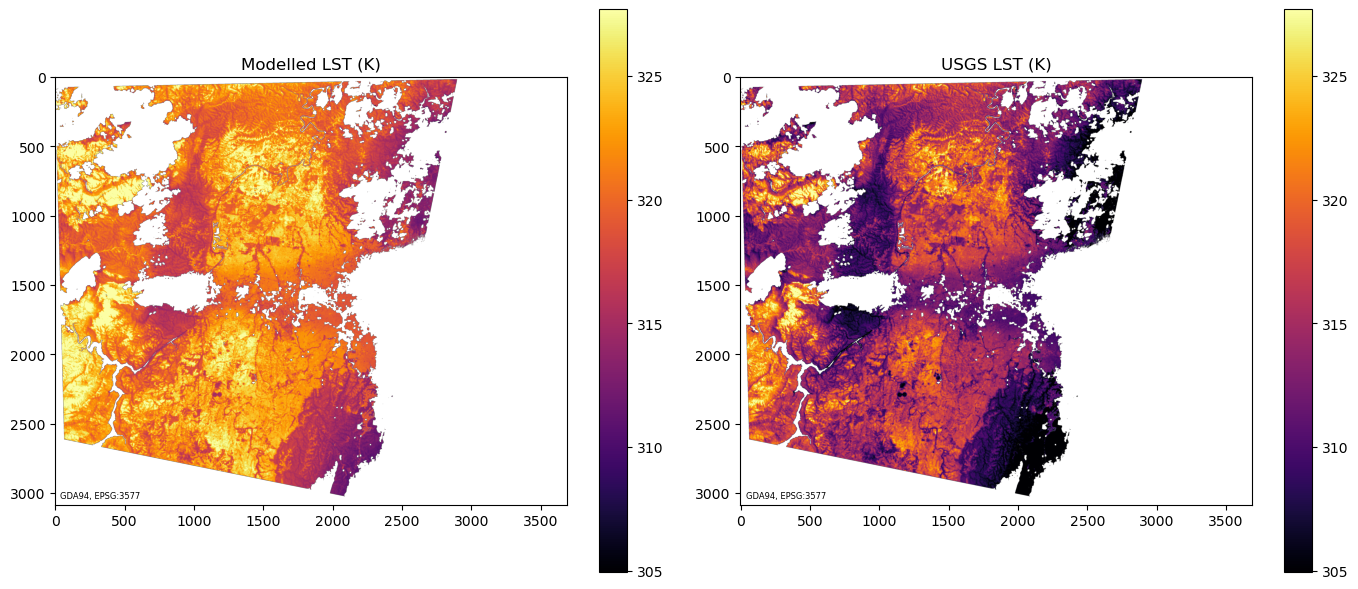

LC08_L2SP_090084_20191113_02_T1: RMSE = 6.062, MAE = 6.019
LC08_L2SP_090084_20191113_02_T1 model C: 298.28248062133787 331.8249801635742 vali C: 291.5143439 326.55930295999997


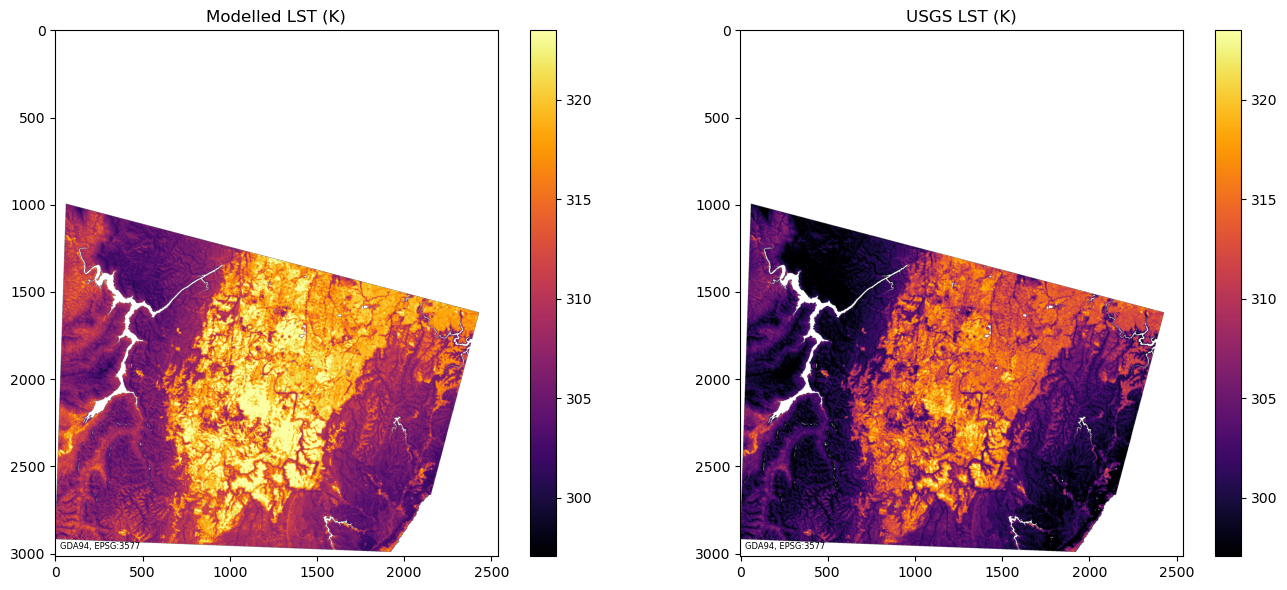

In [28]:
from rasterio.plot import show

in_dir = Path('out/')
v_dir = Path('data/validate')

rmse_list = []

sse_total = 0.0
mae_total = 0.0
n_total = 0

for sid in matches.index:
    out_path = matches.loc[sid, "file"]
    v_path = v_dir / f"{sid}_lwir11.tif"

    model = rxr.open_rasterio(out_path, masked=True).squeeze(drop=True)
    v = rxr.open_rasterio(v_path, masked=True).squeeze(drop=True)

    v_match = v.rio.reproject_match(model)

    model_data = model.values.astype("float64")
    v_data = v_match.values.astype("float64")

    model_data[model_data == -9999] = np.nan
    v_data[v_data == 0] = np.nan
    mask = np.isfinite(model_data) & np.isfinite(v_data)

    v_data = np.where(mask, v_data, np.nan)

    model_data = model_data + 273.15
    v_data = (v_data * 0.00341802) + 149.0 

    diff = model_data[mask] - v_data[mask]
    rmse = np.sqrt(np.mean(diff ** 2))
    abs_diff = np.abs(diff)
    mae = np.nanmean(abs_diff)

    sse_total += np.nansum(diff**2)
    n_total += np.isfinite(diff).sum()
    mae_total += np.nansum(abs_diff)

    rmse_list.append({
        "scene_id": sid,
        "file": out_path,
        "rmse": rmse,
        "mae": mae
    })

    print(f"{sid}: RMSE = {rmse:.3f}, MAE = {mae:.3f}")

    print(
    sid,
    "model C:", np.nanmin(model_data), np.nanmax(model_data),
    "vali C:", np.nanmin(v_data), np.nanmax(v_data)
)

    common_limits = np.concatenate([
        model_data[np.isfinite(model_data)],
        v_data[np.isfinite(v_data)]
    ])

    vmin = np.nanpercentile(common_limits, 2)
    vmax = np.nanpercentile(common_limits, 98)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Left: Modelled LST
    ax1.set_title("Modelled LST (K)")
    im1 = show(
        model_data,
        ax = ax1,
        cmap = "inferno",
        vmin = vmin,
        vmax = vmax,
        origin = "upper"
    )

    ax1.annotate(
        "GDA94, EPSG:3577",
        xy=(0.01, 0.01),
        xycoords='axes fraction',
        fontsize=6,
        ha='left',
        va='bottom',
        bbox=dict(facecolor='white', alpha=0.0, edgecolor='none'),
        zorder=1000
    )
    cbar = fig.colorbar(im1.get_images()[0], ax=ax1)

    # Right: USGS LST
    ax2.set_title("USGS LST (K)")
    im2 = show(
        v_data,
        ax = ax2,
        cmap = "inferno",
        vmin = vmin,
        vmax = vmax,
        origin = "upper"
    )

    ax2.annotate(
        "GDA94, EPSG:3577",
        xy=(0.01, 0.01),
        xycoords='axes fraction',
        fontsize=6,
        ha='left',
        va='bottom',
        bbox=dict(facecolor='white', alpha=0.0, edgecolor='none'),
        zorder=1000
    )
    cbar = fig.colorbar(im2.get_images()[0], ax=ax2)

    # Make sure both subplots share the same x/y limits exactly
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(ax1.get_ylim())

    plt.tight_layout()
    plt.show()

rmse_df = pd.DataFrame(rmse_list)


In [ ]:
rmse_df

global_rmse = np.sqrt(sse_total / n_total)
global_mae = mae_total / n_total

print(f"Global RMSE across all scenes: {global_rmse:.3f} K")
print(f"Global MAE across all scenes: {global_mae:.3f} K")

Global RMSE across all scenes: 6.924 K
Global MAE across all scenes: 6.522 K


In [ ]:
# good_threshold = 8
# bad_threshold = 8

# good_df = rmse_df[rmse_df["rmse"] <= good_threshold]
# bad_df = rmse_df[rmse_df["rmse"] >= bad_threshold]

# good_scenes = good_df["file"].tolist()
# bad_scenes  = bad_df["file"].tolist()